In [1]:
cd ~/Notebooks/show-and-tell/

/home/ec2-user/Notebooks/show-and-tell


## Filepaths

In [2]:
VGG_filepath = './data/imagenet-vgg-verydeep-19.mat' # where pretrained VGG is stored. Download at 

In [3]:
captions_filepath = './data/results_20130124.token'
images_dirpath = './data/flickr30k-images/'

In [4]:
medium_path = './medium'

In [5]:
import os
checkpoint_path = os.path.join(medium_path, 'model.ckpt')

# Model

## Model hyperparameters

In [6]:
caption_length_max = 30
hidden_size = 256 # hidden size for LSTM
wordvec_size = 128
vocab_size = 3000 # including special words

image_height = 224
image_width = 224
image_channels = 3

batch_size = 128

## imports

In [7]:
import tensorflow as tf
import numpy as np
import scipy.io

In [8]:
from collections import OrderedDict

## CNN

In [9]:
def VGG(input_images, scope=None, reuse=None):
    net = OrderedDict() # To store variables
    
    VGG_data = scipy.io.loadmat(VGG_filepath)
    layer_names = [
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',
        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4', 'pool5',
        'fc6', 'relu6', 'fc7'
    ]
    mean = VGG_data['normalization'][0][0][0]
    normalize_value = np.mean(mean, axis=(0,1)).astype('float32')
    
    VGG_layers = VGG_data['layers'][0]
    current = input_images - normalize_value
    with tf.variable_scope(scope, default_name='VGG', reuse=reuse) as VGG:
        for i, layer_name in enumerate(layer_names):
            if layer_name.startswith('conv'):
                kernels_pretrained, bias_pretrained = VGG_layers[i][0][0][0][0]

                # matconvnet: weights are [width, height, in_channels, out_channels]
                # tensorflow: weights are [height, width, in_channels, out_channels]

                kernels = kernels_pretrained.transpose((1, 0, 2, 3))
                biases = bias_pretrained.reshape(-1)

                current = convolutional(current, 
                                        kernels_initial_values=kernels, 
                                        biases_initial_values=biases,
                                        scope=layer_name)

            elif layer_name.startswith('relu'):
                current = tf.nn.relu(current)

            elif layer_name.startswith('pool'):
                current = tf.nn.max_pool(current, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='SAME')

            elif layer_name.startswith('fc'):
                weights_pretrained, biases_pretrained = VGG_layers[i][0][0][0][0]

                weights = weights_pretrained.transpose((1, 0, 2, 3))
                biases = biases_pretrained.reshape(-1)
                
                current = fully_connected(current, 
                                          weights_initial_values=weights,
                                          biases_initial_values=biases,
                                          scope=layer_name)

            net[layer_name] = current
            
    return current, net

## LSTM

In [10]:
def LSTM(image_vec, input_words, target_onehots, mask, bias_init_vector=None, scope=None, reuse=None):
    net = OrderedDict()
    net['current_state'] = OrderedDict()
    loss = 0
    
    with tf.variable_scope(scope, default_name='LSTM', reuse=reuse) as LSTM_scope:
        lstm = tf.contrib.rnn.BasicLSTMCell(hidden_size)
        net['initial_state'] = lstm.zero_state(batch_size, tf.float32)
        _, net['current_state'][-1] = lstm(image_vec, net['initial_state'])
        _, fully_connected(_, output_size=vocab_size, activation_fn=None, scope='fc')
        Wemb = tf.get_variable('Wemb', shape=[vocab_size, wordvec_size], )

        LSTM_scope.reuse_variables()
        for i in range(caption_length_max):

            current_embed = tf.nn.embedding_lookup(Wemb, input_words[:,i])
            output, net['current_state'][i] = lstm(current_embed, net['current_state'][i-1])
    #             net['W'] = tf.get_variable('embed_word_W', initializer=tf.random_uniform([hidden_size, n_words], -0.1, 0.1))
    #             net['b'] - tf.get_variable('embed_word_b', initializer=bias_init_vector)
            net['logit_words'] = fully_connected(output, output_size=vocab_size, activation_fn=None, scope='fc')

            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=net['logit_words'], labels=target_onehots[:,i])
            cross_entropy = cross_entropy * mask[:,i]
            loss = loss + cross_entropy
    
    return tf.reduce_mean(loss), net

## Auxilary functions

In [11]:
def convolutional(inputs, 
                  kernels_initial_values, biases_initial_values, 
                  scope=None, reuse=None):

    with tf.variable_scope(scope, default_name='conv', reuse=reuse):
        kernels = tf.get_variable('kernels', initializer=kernels_initial_values)
        bias = tf.get_variable('bias', initializer=biases_initial_values)

        conv = tf.nn.conv2d(inputs, kernels, strides=(1, 1, 1, 1), padding='SAME')
        outputs = tf.nn.bias_add(conv, bias)
        
    return outputs

In [12]:
def fully_connected(inputs, output_size=None, 
                    weights_initial_values=None, biases_initial_values=None, activation_fn=None,
                    scope=None, reuse=None):
    
    with tf.variable_scope(scope, default_name='fc', reuse=reuse):
        
        dimension_reduced = inputs.shape[1]
        for dimension in inputs.shape[2:]:
            dimension_reduced *= dimension

        x = tf.reshape(inputs, shape=[-1, dimension_reduced.value])

        if weights_initial_values is not None:
            weights_initial_values_flat = tf.reshape(weights_initial_values, shape=[dimension_reduced.value, -1])
            weights = tf.get_variable('weights', initializer=weights_initial_values_flat)
        else:
            weights = tf.get_variable('weights', shape=[dimension_reduced, output_size])
        if biases_initial_values is not None:
            biases = tf.get_variable('biases', initializer=biases_initial_values)
        else:
            biases = tf.get_variable('biases', shape=[output_size])

        outputs = tf.nn.bias_add(tf.matmul(x, weights), biases)

        if activation_fn:
            return activation_fn(outputs)
        else:
            return outputs

## Build model

In [13]:
network = OrderedDict() # To store all variables from the model

In [14]:
input_images = tf.placeholder(tf.float32, shape=(batch_size, image_height, image_width, image_channels))
input_words = tf.placeholder(tf.int32, [batch_size, caption_length_max])
target_onehots = tf.placeholder(tf.int32, [batch_size, caption_length_max, vocab_size])
mask = tf.placeholder(tf.float32, [batch_size, caption_length_max])

In [15]:
%%time
final_layer, network['VGG'] = VGG(input_images, scope='VGG')
network['image_embedded'] = fully_connected(final_layer, output_size=wordvec_size, scope='embed_image')
loss, network['LSTM'] = LSTM(network['image_embedded'], input_words, target_onehots, mask, bias_init_vector=None, scope='LSTM')

CPU times: user 8.75 s, sys: 640 ms, total: 9.39 s
Wall time: 9.38 s


# Preprocessing

In [16]:
import cv2
import skimage.io

In [17]:
import pandas as pd

In [18]:
from os.path import join

In [19]:
from collections import Counter

In [20]:
from keras.preprocessing import sequence

Using TensorFlow backend.


In [21]:
image_captions = (pd.read_table(captions_filepath, sep='\t', header=None, names=['image', 'caption'])
           .assign(image_num = lambda x: x['image'].map(lambda x: x.split('#')[1]))
           .assign(image = lambda x: x['image'].map(lambda x: join(images_dirpath, x.split('#')[0])))
           )

In [22]:
image_captions.head()

,image,caption,image_num
0,./data/flickr30k-images/1000092795.jpg,Two young guys with shaggy hair look at their ...,0
1,./data/flickr30k-images/1000092795.jpg,"Two young , White males are outside near many ...",1
2,./data/flickr30k-images/1000092795.jpg,Two men in green shirts are standing in a yard .,2
3,./data/flickr30k-images/1000092795.jpg,A man in a blue shirt standing in a garden .,3
4,./data/flickr30k-images/1000092795.jpg,Two friends enjoy time spent together .,4


In [23]:
def build_vocaburary(sentences):
    counter = Counter()
    for sentence in sentences:
        words = sentence.lower().split()
        counter.update(words)

    vocab_words = counter.most_common(vocab_size - 1) # minus one for special words
    # Special token for the start of a sentence
    vocab_words.insert(0, ('start_token', 0))
    
    word_to_index = {}
    index_to_word = {} 
    for index, (word, count) in enumerate(vocab_words):
        word_to_index[word] = index
        index_to_word[index] = word
    
    return word_to_index, index_to_word

In [24]:
def process_captions(captions, word_to_index, index_to_word):
    
    input_matrix = []
    target_matrix = []
    mask_matrix = []
    for caption in captions:
        
        word_indices = [word_to_index[word] for word in caption.lower().split() if word in word_to_index]

        caption_length = len(word_indices[:caption_length_max])
        
        words_padded = [0] + word_indices[:caption_length_max] + [0] * (caption_length_max - caption_length)
        
        input_words = words_padded[0:caption_length_max]
        target_words = words_padded[1:caption_length_max + 1]
        mask = np.concatenate([np.ones(caption_length), np.zeros(caption_length_max-caption_length)])
        
        target_onehots = np.zeros((caption_length_max, vocab_size))
        target_onehots[np.arange(caption_length_max), target_words] = 1
        
        input_matrix.append(input_words)
        target_matrix.append(target_onehots)
        mask_matrix.append(mask)
    
    return np.array(input_matrix), np.stack(target_matrix), np.array(mask_matrix)

In [25]:
all_captions = image_captions.caption.values
word_to_index, index_to_word = build_vocaburary(all_captions)

In [26]:
def crop_image(x, target_height=256, target_width=256):
    image = skimage.io.imread(x).astype(np.float32)

    height, width, rgb = image.shape
    if width == height:
        resized_image = cv2.resize(image, (target_height,target_width))

    elif height < width:
        resized_image = cv2.resize(image, (int(width * float(target_height)/height), target_width))
        cropping_length = int((resized_image.shape[1] - target_height) / 2)
        resized_image = resized_image[:,cropping_length:resized_image.shape[1] - cropping_length]

    else:
        resized_image = cv2.resize(image, (target_height, int(height * float(target_width) / width)))
        cropping_length = int((resized_image.shape[0] - target_width) / 2)
        resized_image = resized_image[cropping_length:resized_image.shape[0] - cropping_length,:]

    return cv2.resize(resized_image, (target_height, target_width))

In [27]:
def process_images(image_paths):
    cropped_images = [crop_image(image_path, image_height, image_width) for image_path in image_paths]
    return np.stack(cropped_images)

# Training

You can skip this part and go to the inference part if you have a pretrained model.

## Training hyperparameters

In [28]:
TRAIN_CNN = False # Whether to train CNN part

In [29]:
training_epochs = 100
save_epoch = 1
print_epoch = 1
learning_rate = 0.001

In [30]:
data_size = len(image_captions)
data_size

158915

## Optimizer

In [31]:
optimizer = tf.train.AdamOptimizer(learning_rate)

In [32]:
if TRAIN_CNN:
    trainer = optimizer.minimize(loss)
else:
    variables_to_train = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='[^VGG]')
    trainer = optimizer.minimize(loss, var_list=variables_to_train)

## Initializing

In [33]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
epoch = 0

In [34]:
saver = tf.train.Saver(max_to_keep=50)

## Running

In [35]:
from tqdm import tqdm

In [ ]:
for _ in tqdm(range(epoch, training_epochs)):

    cost_list = []
    np.random.shuffle(image_captions.values)
    for batch_end in tqdm(range(batch_size, data_size, batch_size)):
#     for batch_start in range(0, 100, batch_size):
        minibatch = image_captions[batch_end-batch_size:batch_end]
        training_images = process_images(minibatch.image.values)
        training_input_words, training_target_onehots, training_mask = process_captions(minibatch.caption.values, 
                                                            word_to_index=word_to_index, 
                                                            index_to_word=index_to_word)
        
        feed = {input_images:training_images, 
                input_words:training_input_words, 
                target_onehots:training_target_onehots,
                mask:training_mask}
        
        _, current_loss = sess.run([trainer, loss], feed_dict=feed)
        
        cost_list.append(current_loss)

    epoch += 1
    
    if epoch % print_epoch == 0:
        print("Epoch: {epoch:<5d}  Loss: {loss:<.6}".format(
                epoch=epoch,
                loss=np.mean(cost_list),
                ),
              flush=True
              )
        
    if epoch % save_epoch == 0:
        saver.save(sess, checkpoint_path, global_step=epoch)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1241 [00:00<?, ?it/s]

 24%|██▍       | 304/1241 [16:35<51:09,  3.28s/it]

# Inference

## Caption generator

In [44]:
def caption_generator(image_vec, scope=None, reuse=None):
    net = OrderedDict()
    net['current_state'] = OrderedDict()

    with tf.variable_scope(scope, default_name='LSTM', reuse=reuse) as LSTM_scope:
        lstm = tf.contrib.rnn.BasicLSTMCell(hidden_size)
        net['initial_state'] = lstm.zero_state(1, tf.float32)
        _, net['current_state'][-1] = lstm(image_vec, net['initial_state'])
        Wemb = tf.get_variable('Wemb', shape=[vocab_size, wordvec_size], )
        
        last_word = [0] # index for #START#
        generated_words = []
        for i in range(caption_length_max):

            current_embed = tf.nn.embedding_lookup(Wemb, last_word)
            output, net['current_state'][i] = lstm(current_embed, net['current_state'][i-1])
    #             net['W'] = tf.get_variable('embed_word_W', initializer=tf.random_uniform([hidden_size, n_words], -0.1, 0.1))
    #             net['b'] - tf.get_variable('embed_word_b', initializer=bias_init_vector)
            net['logit_words'] = fully_connected(output, output_size=vocab_size, activation_fn=None, scope='fc')
            
            last_word = tf.argmax(net['logit_words'], axis=1)
            generated_words.append(last_word)
            
    return generated_words, net

## Building generator

In [45]:
infer_image = tf.placeholder(tf.float32, shape=(1, image_height, image_width, image_channels))

In [46]:
final_layer, network['VGG'] = VGG(infer_image, scope='VGG', reuse=True)
network['image_embedded'] = fully_connected(final_layer, output_size=wordvec_size, scope='embed_image', reuse=True)
generated_words, network['LSTM'] = caption_generator(network['image_embedded'], scope='LSTM', reuse=True)

## Loading variables

In [53]:
checkpoints = [filename.split(".data")[0] for filename in os.listdir(medium_path) 
                        if filename.endswith('.data-00000-of-00001')]
latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('ckpt-')[1]))

In [54]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, os.path.join(medium_path, latest_checkpoint))

InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [3000] rhs shape= [3002]
	 [[Node: save_1/Assign_9 = Assign[T=DT_FLOAT, _class=["loc:@LSTM/fc/biases"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](LSTM/fc/biases, save_1/RestoreV2_9)]]

Caused by op 'save_1/Assign_9', defined at:
  File "/Users/dreamgonfly/anaconda/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-54-0258123fa0de>", line 2, in <module>
    saver = tf.train.Saver()
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1051, in __init__
    self.build()
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1081, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 675, in build
    restore_sequentially, reshape)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 414, in _AddRestoreOps
    assign_ops.append(saveable.restore(tensors, shapes))
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 155, in restore
    self.op.get_shape().is_fully_defined())
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/gen_state_ops.py", line 47, in assign
    use_locking=use_locking, name=name)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [3000] rhs shape= [3002]
	 [[Node: save_1/Assign_9 = Assign[T=DT_FLOAT, _class=["loc:@LSTM/fc/biases"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](LSTM/fc/biases, save_1/RestoreV2_9)]]


## Generate

In [55]:
cat = process_images(['cat.jpg'])

In [56]:
n = sess.run(network, feed_dict={infer_image:cat})

FailedPreconditionError: Attempting to use uninitialized value LSTM/Wemb
	 [[Node: LSTM/Wemb/read = Identity[T=DT_FLOAT, _class=["loc:@LSTM/Wemb"], _device="/job:localhost/replica:0/task:0/cpu:0"](LSTM/Wemb)]]

Caused by op 'LSTM/Wemb/read', defined at:
  File "/Users/dreamgonfly/anaconda/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-68ef11d5b5d8>", line 3, in <module>
    loss, network['LSTM'] = LSTM(network['image_embedded'], input_words, target_onehots, mask, bias_init_vector=None, scope='LSTM')
  File "<ipython-input-10-741f1c9e4d95>", line 11, in LSTM
    Wemb = tf.get_variable('Wemb', shape=[vocab_size, wordvec_size], )
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 988, in get_variable
    custom_getter=custom_getter)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 890, in get_variable
    custom_getter=custom_getter)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 348, in get_variable
    validate_shape=validate_shape)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 333, in _true_getter
    caching_device=caching_device, validate_shape=validate_shape)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 684, in _get_single_variable
    validate_shape=validate_shape)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 226, in __init__
    expected_shape=expected_shape)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 344, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1490, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/dreamgonfly/anaconda/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value LSTM/Wemb
	 [[Node: LSTM/Wemb/read = Identity[T=DT_FLOAT, _class=["loc:@LSTM/Wemb"], _device="/job:localhost/replica:0/task:0/cpu:0"](LSTM/Wemb)]]


In [ ]:
n['VGG']['fc7']

In [ ]:
words = sess.run(generated_words, feed_dict={infer_image:cat})

In [ ]:
c = Counter()

In [ ]:
{'#START#'}

In [ ]:
type(_)

In [ ]:
c.update(['#START#'])

In [ ]:
c

In [ ]:
[index_to_word[word] for word in np.hstack(words)]

# Left over

In [ ]:
def preProBuildWordVocab(sentence_iterator, word_count_threshold=30): # borrowed this function from NeuralTalk
    print('preprocessing word counts and creating vocab based on word count threshold %d' % (word_count_threshold, ))
    word_counts = {}
    nsents = 0
    for sent in sentence_iterator:
        nsents += 1
        for w in sent.lower().split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1
    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    print('filtered words from %d to %d' % (len(word_counts), len(vocab)))

    ixtoword = {}
    ixtoword[0] = '.'  # period at the end of the sentence. make first dimension be end token
    wordtoix = {}
    wordtoix['#START#'] = 0 # make first vector be the start token
    ix = 1
    for w in vocab:
        wordtoix[w] = ix
        ixtoword[ix] = w
        ix += 1

    word_counts['.'] = nsents
    bias_init_vector = np.array([1.0*word_counts[ixtoword[i]] for i in ixtoword])
    bias_init_vector /= np.sum(bias_init_vector) # normalize to frequencies
    bias_init_vector = np.log(bias_init_vector)
    bias_init_vector -= np.max(bias_init_vector) # shift to nice numeric range
    return wordtoix, ixtoword, bias_init_vector

In [ ]:
skimage.io.imread('./data/flickr30k-images/1000092795.jpg', )

# Appendix

## VGG

In [36]:
example_image = process_images(['cat.jpg'])

In [37]:
example_image.shape

(1, 224, 224, 3)

In [38]:
example_final, example_net = VGG(example_image, scope='VGG', reuse=True)

In [39]:
%matplotlib inline
from matplotlib import pyplot as plt

conv1_1


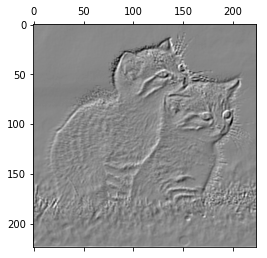

relu1_1


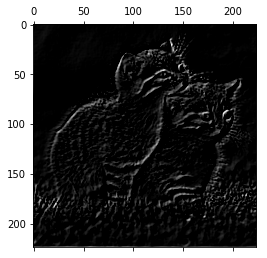

conv1_2


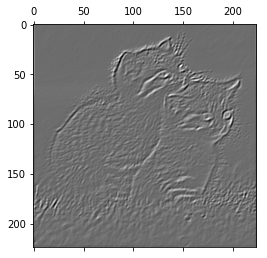

relu1_2


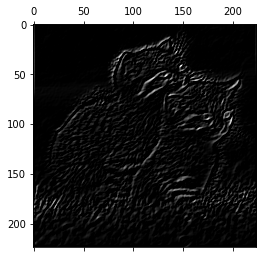

pool1


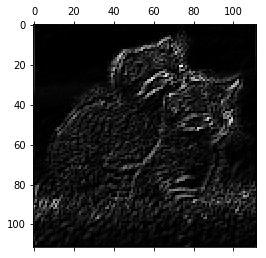

conv2_1


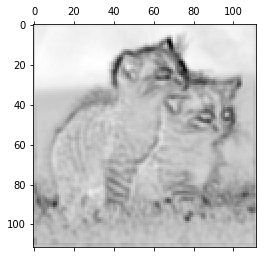

relu2_1


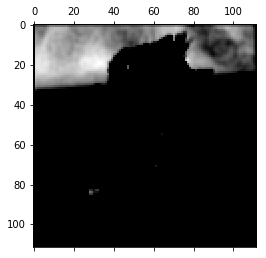

conv2_2


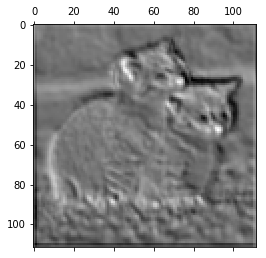

relu2_2


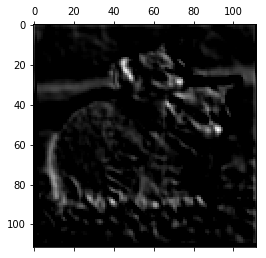

pool2


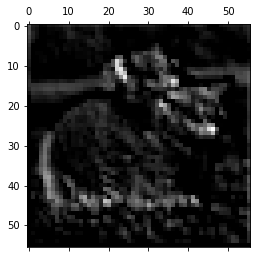

conv3_1


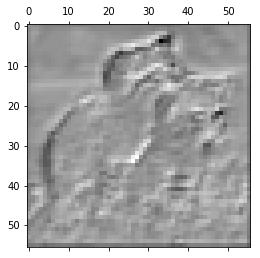

relu3_1


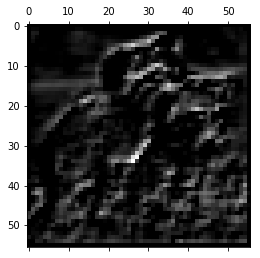

conv3_2


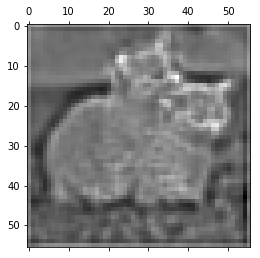

relu3_2


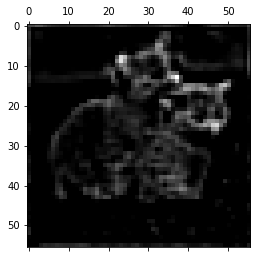

conv3_3


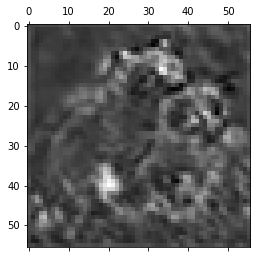

relu3_3


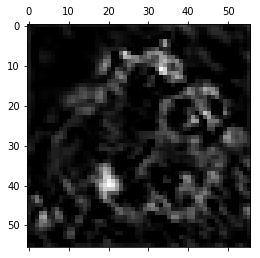

conv3_4


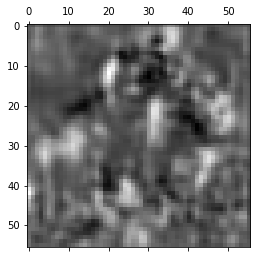

relu3_4


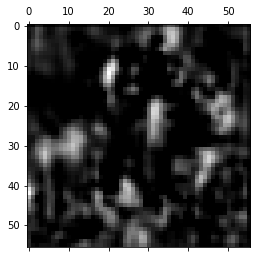

pool3


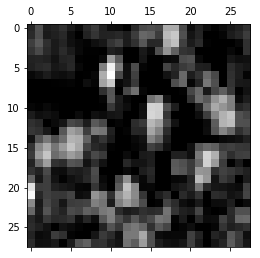

conv4_1


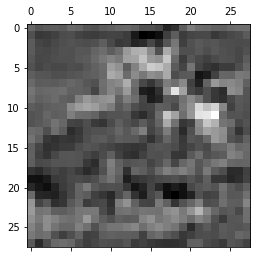

relu4_1


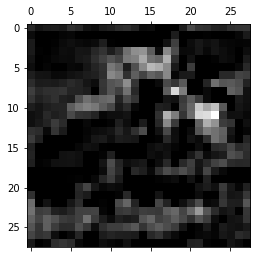

conv4_2


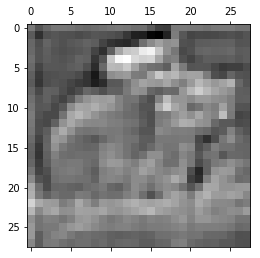

relu4_2


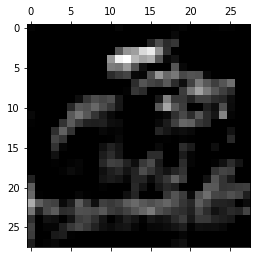

conv4_3


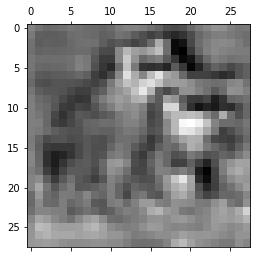

relu4_3


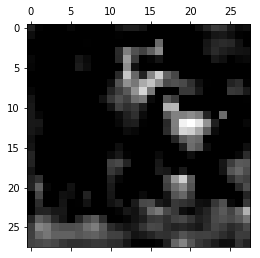

conv4_4


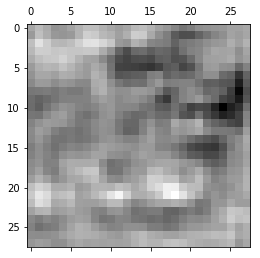

relu4_4


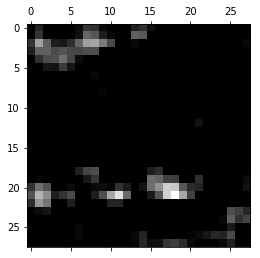

pool4


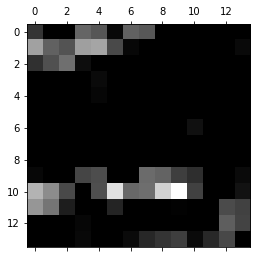

conv5_1


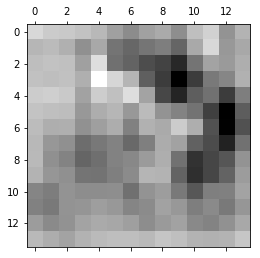

relu5_1


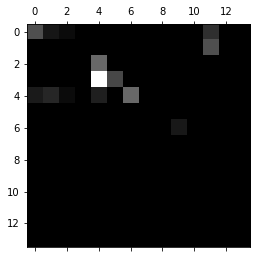

conv5_2


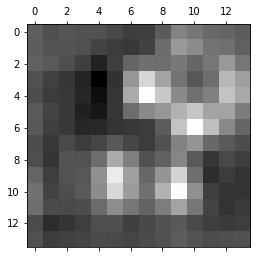

relu5_2


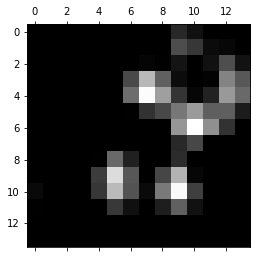

conv5_3


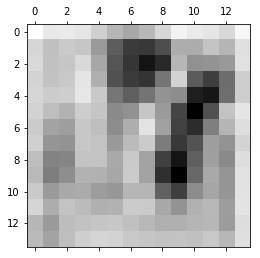

relu5_3


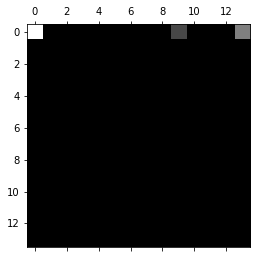

conv5_4


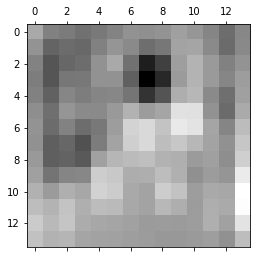

relu5_4


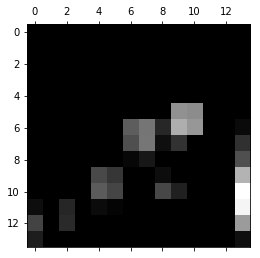

pool5


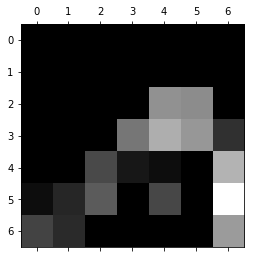

In [45]:
for layer_name in example_net:
    if layer_name.startswith('fc'): break
    print(layer_name)
    plt.matshow(example_net[layer_name].eval()[0, :, :, 0], cmap=plt.cm.gray)
    plt.show();